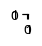

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

In [2]:
total_exp=pd.read_csv(f'../output/TCRBASE/total_mean_exp_results.csv', index_col=0)
total_old=pd.read_csv(f'../output/TCRBASE/total_mean_old_results.csv', index_col=0)
exp_filt = total_exp.query('n_pos>=75').sort_values('auc',ascending=False).head(17).index
total_exp.query('n_pos>75').sort_values('auc',ascending=False).head(17).sort_index()

,n_pos,auc,auc_01,auc_01_real,precision,recall,accuracy,AP,partition
peptide,,,,,,,,,
AVFDRKSDAK,143.4,0.537760,0.523512,0.094672,0.166668,1.0,0.166668,0.216992,2.0
ELAGIGILTV,91.4,0.913552,0.809742,0.638514,0.166668,1.0,0.166668,0.782364,2.0
GILGFVFTL,233.0,0.829168,0.744974,0.515450,0.166670,1.0,0.166670,0.634484,2.0
KLGGALQAK,180.2,0.583082,0.561664,0.167164,0.166664,1.0,0.166664,0.289294,2.0
RAKFKQLL,166.0,0.901230,0.833696,0.684024,0.166670,1.0,0.166670,0.779796,2.0
SPRWYFYYL,89.8,0.671422,0.649950,0.334904,0.166670,1.0,0.166670,0.475666,2.0
TTDPSFLGRY,77.4,0.672200,0.632344,0.301454,0.166666,1.0,0.166666,0.458376,2.0
YLQPRTFLL,79.8,0.731442,0.694864,0.420246,0.166662,1.0,0.166662,0.573052,2.0


# inits

In [2]:
def get_agg_matrix(dm_vae, dm_base, index_col='raw_index', cols = ('peptide', 'original_peptide','raw_index', 'binder', 'partition')):
    if not all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]):
        dm_base, values_base = resort_baseline(dm_base, dm_vae, index_col)
    else:
        values_base = None
    values_vae = dm_vae.iloc[:len(dm_vae), :len(dm_vae)].values
    if values_base is None:
        values_base = dm_base.iloc[:len(dm_base), :len(dm_base)].values
    assert all([x==y for x,y in zip(dm_vae[index_col].values, dm_base[index_col].values)]) and len(dm_vae)==len(dm_base)
    agg_values = 1-np.multiply(1-values_vae, 1-values_base)
    agg_dm = pd.DataFrame(agg_values)
    agg_dm[list(cols)] = dm_vae[list(cols)].values
    return agg_dm, agg_dm.iloc[:len(agg_dm), :len(agg_dm)].values

def plot_prune_heatmap(values, threshold, title, 
                       filename=None, outdir='../output/240618_NestedKCV_CNNVAE/notebook_figs/',
                       sorted_dm=None,
                       cmap='icefire', color='g', addline=True):
    # prune and plot the heatmap
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=threshold, cbar_ax=cbar_ax, cmap=cmap)
    # Set up custom tickmarks if available
    if sorted_dm is not None:
        pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
        pepmap['idx']=pepmap['count'].cumsum()
        pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
        tickmarks = pepmap['tick'].to_dict() 
        idxs = pepmap['idx'].to_dict()
        ax.set_xticks(list(tickmarks.values()))
        ax.set_yticks(list(tickmarks.values()))
        ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
        ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline and sorted_dm is not None:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    if filename is not None:
        f.savefig(f'{outdir}heatmaps/{filename}.png', dpi=150, bbox_inches='tight')
    

In [3]:
model_ts128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
# model_os128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ.pt',
#                               '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ_JSON_kwargs.json',
#                               map_location='cpu', verbose=False)
# model_os256 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/epoch_8000_interval_checkpoint__fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02.pt',
#                               '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_latent_256_kld_1e-2_ExpData_KFold_0_240618_1607_vnN02_JSON_kwargs.json',
#                               map_location='cpu', verbose=False)

# model_ts128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm/epoch_4000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm.pt',
#                                     '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1232_ph8wm_JSON_kwargs.json',
#                                     map_location='cpu', verbose=False)
# model_os128_notrp = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni.pt',
#                                     '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/checkpoint_best_fold00_kcv_240618_nettcr_exp_nested_posonly_train_p0234_f00_Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni_JSON_kwargs.json',
#                               map_location='cpu', verbose=False)

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()


# Try on some random downloaded repertoire data

## metadata parsing

In [4]:
import csv
def get_metadata(filename):
    # Initialize a dictionary to hold the header information
    metadatares = {'filename':os.path.basename(filename)}
    metadatares['relpath']=filename
    # Read the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Read the first line which contains the metadata
        metadata_line = next(reader)[0]
        # Convert the metadata line to a dictionary
        metadata = eval(metadata_line)
    metadatares.update(metadata)
    return metadatares
    
def read_ots_data(filename):
    metadata = get_metadata(filename)
    df = pd.read_csv(filename, skiprows=1)
    df = df[[c for c in df.columns if ('aa' in c.lower() and 'cdr' in c.lower()) or 'call' in c.lower()]]
    df.columns = [x.replace('cdr','').replace('_aa_','').replace('beta','B').replace('alpha','A')[::-1] if 'cdr' in x else x for x in df.columns]
    df.columns = df.columns.str.replace('_call','')
    df['Link']=metadata['Link']
    df['Disease']=metadata['Disease']
    df['CancerType']=metadata['CancerType']
    df['Source']=metadata['TSource']
    df['Subject']=metadata['Subject']
    return df, metadata


def plot_prune_heatmap(values, threshold, title, 
                       filename=None, outdir='../output/240618_NestedKCV_CNNVAE/notebook_figs/',
                       sorted_dm=None,
                       cmap='vlag', color='g', addline=True):
    # prune and plot the heatmap
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=values.max(), cbar_ax=cbar_ax, cmap=cmap)
    # Set up custom tickmarks if available
    if sorted_dm is not None:
        pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
        pepmap['idx']=pepmap['count'].cumsum()
        pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
        tickmarks = pepmap['tick'].to_dict() 
        idxs = pepmap['idx'].to_dict()
        ax.set_xticks(list(tickmarks.values()))
        ax.set_yticks(list(tickmarks.values()))
        ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
        ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline and sorted_dm is not None:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    if filename is not None:
        f.savefig(f'{outdir}{filename}.png', dpi=150, bbox_inches='tight')
    plt.close()
    del f, ax

def do_all(filename, model, noplot=False, unique=False, outdir='../output/240820_HumanRepertoires/'):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    if unique:
        df.drop_duplicates(subset=['tcr'], inplace=True)
    metadata['n_seq'] = len(df)
    metadata['n_unique'] = len(df['tcr'].unique())
    pd.DataFrame(metadata, index=[0]).to_csv(f"{outdir}metadata/{metadata['Run']}_metadata.txt", index=False)
    if noplot:
        return 0
    else:
            
        if len(glob.glob(f'{outdir}heatmaps/*{metadata["Run"]}*'))>0:
            return 0
    
        latent_df = get_latent_df(model, df)
        latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
        _, values_array, _, _, _, _ = get_distances_labels_from_latent(latent_df, 
                                                                       label_col='Disease', 
                                                                       index_col='index_col',
                                                                       rest_cols=['Disease','CancerType','Source'],
                                                                       low_memory=True)
        
        latent_df['tcr'] = latent_df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
        n_seq=len(latent_df)
        n_unique=len(latent_df['tcr'].unique())
        plot_prune_heatmap(values_array, threshold=10, title=f"{metadata['Run']}, n_seq={n_seq}, n_unique={n_unique}", 
                           filename=f'{metadata["Run"]}_n-{n_seq}_unique-{n_unique}',
                           outdir=f'{outdir}heatmaps/', addline=False, sorted_dm=None)
        print(metadata['Run'], '\t', n_seq, '\t', n_unique)
        del latent_df
    # latent_df.groupby(['tcr']).agg(count=('B1','count')).sort_values('count',ascending=False)

## init

In [5]:
meta_df = pd.read_csv('../data/OTS/human/METADATA.txt')
meta_df.groupby(['Link','Author']).agg(disease=('Disease','unique'),
                                      n_repertoires=('Disease','count'),
                                      mean_size=('Sequences', 'mean'),
                                      mean_unique=('n_unique','mean'))

,,disease,n_repertoires,mean_size,mean_unique
Link,Author,,,,
https://pubmed.ncbi.nlm.nih.gov/33478949/,Kusnadi et al. 2021,[covid],15,4657.133333,734.266667
https://pubmed.ncbi.nlm.nih.gov/34156975/,"Peng et al., 2021",[herpes_simplex_virus_type_2],4,1324.250000,681.250000
https://pubmed.ncbi.nlm.nih.gov/34793243/,Francis et al. 2021,[covid],95,1655.589474,821.357895
https://pubmed.ncbi.nlm.nih.gov/36516854/,Yu et al. 2022,[cmv],6,2545.833333,733.500000
https://pubmed.ncbi.nlm.nih.gov/37580605/,Garner et al.,[healthy],96,5587.364583,1663.104167
https://www.nature.com/articles/s41590-022-01367-z,Xu et al. 2023,[covid],8,4370.750000,3346.875000
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10201342/,Eberhardt et al. 2021,[cancer],51,1234.333333,191.705882


# Sample run

In [6]:
df, metadata = read_ots_data('../data/SRR15178288_1_Paired_All.csv')
df.sort_values('B3')

,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,A1,A2,A3,Link,Disease,CancerType,Source,Subject
1384,TRBV19*01,TRBD1*01,TRBJ1-3*01,LNHDA,SQIVND,ASFNRVGGNTIY,TRAV17*01,NaN,TRAJ37*02,TSINN,IRSNERE,ASHSSNTGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
1303,TRBV11-2*01,TRBD1*01,TRBJ1-1*01,SGHAT,FQNNGV,ASNEGTYTEAF,TRAV19*01,NaN,TRAJ23*01,TRDTTYY,RNSFDEQN,ALSLGGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
1203,TRBV11-2*01,TRBD1*01,TRBJ1-1*01,SGHAT,FQNNGV,ASNEGTYTEAF,TRAV19*01,NaN,TRAJ23*01,TRDTTYY,RNSFDEQN,ALSLGGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
1739,TRBV11-2*01,TRBD1*01,TRBJ1-1*01,SGHAT,FQNNGV,ASNEGTYTEAF,TRAV19*01,NaN,TRAJ23*01,TRDTTYY,RNSFDEQN,ALSLGGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
862,TRBV11-2*01,TRBD1*01,TRBJ1-1*01,SGHAT,FQNNGV,ASNEGTYTEAF,TRAV19*01,NaN,TRAJ23*01,TRDTTYY,RNSFDEQN,ALSLGGKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,TRBV20-1*01,TRBD2*01,TRBJ2-2*01,DFQATT,SNEGSKA,SARPTPGGGLPDTGELF,TRAV21*01,NaN,TRAJ32*02,DSAIYN,IQSSQRE,AVLGGATNKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
1278,TRBV20-1*01,TRBD2*01,TRBJ2-2*01,DFQATT,SNEGSKA,SARPTPGGGLPDTGELF,TRAV21*01,NaN,TRAJ32*02,DSAIYN,IQSSQRE,AVLGGATNKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
587,TRBV20-1*01,TRBD2*01,TRBJ2-2*01,DFQATT,SNEGSKA,SARPTPGGGLPDTGELF,TRAV21*01,NaN,TRAJ32*02,DSAIYN,IQSSQRE,AVLGGATNKLI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7
982,TRBV20-1*01,TRBD2*01,TRBJ2-2*01,DFQATT,SNEGSKA,SARPTPGGGLPDTGELF,TRAV26-1*02,NaN,TRAJ52*01,TISGNEY,GLKNN,IVRVSNAGGTSYGKLT,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7


In [7]:
df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
counts = df.groupby('tcr').agg(count=('B3','count'))
df = df.drop_duplicates(subset=['tcr'])
df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
df

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,A1,A2,A3,Link,Disease,CancerType,Source,Subject,count
0,VSPFSNMTFSENTVVRGDYKLSMNHNSSASEGTASSEGGDRAYGYT,TRBV6-1*01,TRBD1*01,TRBJ1-2*01,MNHNS,SASEGT,ASSEGGDRAYGYT,TRAV10*01,NaN,TRAJ20*01,VSPFSN,MTFSENT,VVRGDYKLS,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,83
1,DSAIYNIQSSQREAADTGGFKTIMNHEYSMNVEVASTGGDYNSPLH,TRBV27*01,TRBD1*01,TRBJ1-6*02,MNHEY,SMNVEV,ASTGGDYNSPLH,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AADTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,165
2,TSINNIRSNEREATDEGGGQKLLSGHATFQNNGVASSLEAANYGYT,TRBV11-2*01,NaN,TRBJ1-2*01,SGHAT,FQNNGV,ASSLEAANYGYT,TRAV17*01,NaN,TRAJ16*01,TSINN,IRSNERE,ATDEGGGQKLL,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,6
3,DSAIYNIQSSQREAVDTGGFKTIMNHEYSVGAGIASSYSDGNYGYT,TRBV6-5*01,NaN,TRBJ1-2*01,MNHEY,SVGAGI,ASSYSDGNYGYT,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AVDTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,149
4,DSAIYNIQSSQREAVDTGGFKTIMNHEYSVGAGIASTRLSGDYGYT,TRBV6-5*01,TRBD2*01,TRBJ1-2*01,MNHEY,SVGAGI,ASTRLSGDYGYT,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AVDTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,95
5,DSAIYNIQSSQREAVDTGGFKTIMNHEYSMNVEVASTHGDRAGELF,TRBV27*01,TRBD1*01,TRBJ2-2*01,MNHEY,SMNVEV,ASTHGDRAGELF,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AVDTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,98
6,TRDTTYYRNSFDEQNALVKYSGAGSYQLTDFQATTSNEGSKASAQD...,TRBV20-1*02,TRBD1*01,TRBJ1-2*01,DFQATT,SNEGSKA,SAQDRVGYGYT,TRAV19*01,NaN,TRAJ28*01,TRDTTYY,RNSFDEQN,ALVKYSGAGSYQLT,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,41
7,YGATPYYFSGDTLVAVGDGGGSNYKLTLNHDASQIVNDASSFLGRR...,TRBV19*01,TRBD2*01,TRBJ2-1*01,LNHDA,SQIVND,ASSFLGRRGGGDEQF,TRAV8-3*01,NaN,TRAJ53*01,YGATPY,YFSGDTLV,AVGDGGGSNYKLT,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,61
8,DSAIYNIQSSQREAVDTGGFKTIMNHEYSMNVEVASTPGDGNYGYT,TRBV27*01,TRBD1*01,TRBJ1-2*01,MNHEY,SMNVEV,ASTPGDGNYGYT,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AVDTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,61
9,DSAIYNIQSSQREAADTGGFKTIMNHEYSMNVEVASSPADRGDGYT,TRBV27*01,TRBD1*01,TRBJ1-2*01,MNHEY,SMNVEV,ASSPADRGDGYT,TRAV21*01,NaN,TRAJ9*01,DSAIYN,IQSSQRE,AADTGGFKTI,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,cancer,hpv+_hnscc,metastatic_lymph_node,hpv7,73


In [8]:
def read_ots_unique(filename):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    metadata['n_seq'] = len(df)
    metadata['unique'] = len(df.tcr.unique())
    counts = df.groupby('tcr').agg(count=('B3','count'))
    df = df.drop_duplicates(subset=['tcr'])
    df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
    return df, metadata

In [9]:
df, metadata = read_ots_unique('../data/OTS/human/SRR12164411_1_Paired_All.csv')
latent_df = get_latent_df(model_ts128, df)
latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
dist_matrix, values_array, _, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_df, 
                                                                                                       label_col='Disease', 
                                                                                                       index_col='index_col',
                                                                                                       rest_cols=['Disease','CancerType','Source'])

### params

In [10]:
initial_cut_threshold=1
initial_cut_method='top'
filename=metadata['Run']

### Running the algos for baselines

In [11]:
# TBCRALIGN
dist_matrix['index_col'] = [f'id_{i:04}' for i in range(len(dist_matrix))]
G, tree, dist_matrix, values_array, labels, encoded_labels, label_encoder, raw_indices = create_mst_from_distance_matrix(dist_matrix, label_col='Disease',
                                                                                                                   index_col='index_col', algorithm='kruskal')

# NO INITIAL PRUNING
tree_cut, subgraphs, size_clusters, edges_cut, nodes_cut, size_scores, size_purities, size_retentions = iterative_size_cut(values_array, tree, 
                                                                                                         initial_cut_threshold=initial_cut_threshold, 
                                                                                                         initial_cut_method=initial_cut_method, 
                                                                        top_n=1, which='edge', weighted=True, verbose=0, max_size=4)

tree_cut, subgraphs, topn_clusters, edges_removed, nodes_removed, topn_scores, topn_purities, topn_retentions = iterative_topn_cut(values_array, tree, 
                                                                                                                    initial_cut_threshold=initial_cut_threshold, 
                                                                                                                    initial_cut_method=initial_cut_method, 
                                                                                                                    top_n=1, which='edge', weighted=True, 
                                                                                                                    verbose=0, score_threshold=.5)
print(np.mean([x['cluster_size'] for x in topn_clusters]), np.mean([x['cluster_size'] for x in size_clusters]))

Initial mean purity, silhouette score, retention
1.0 0.0264 1.0
2.1548387096774193 2.529032258064516


In [12]:
cluster_test = cluster_all_thresholds(values_array, values_array, labels, encoded_labels, label_encoder, n_jobs=8)

HERE


  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
cluster_test.loc[cluster_test['silhouette'].idxmax()]

threshold               0.722040
n_cluster             158.000000
n_singletons           32.000000
n_cluster_over_70p    158.000000
mean_purity             1.000000
min_purity              1.000000
max_purity              1.000000
mean_coherence          0.589050
min_coherence           0.070074
max_coherence           0.711213
mean_cluster_size       2.436709
min_cluster_size        2.000000
max_cluster_size        7.000000
silhouette              0.116948
ch_index                3.696867
db_index                1.175489
ARI                     0.000000
retention               0.923261
Name: 256, dtype: float64

### silhouette score plots

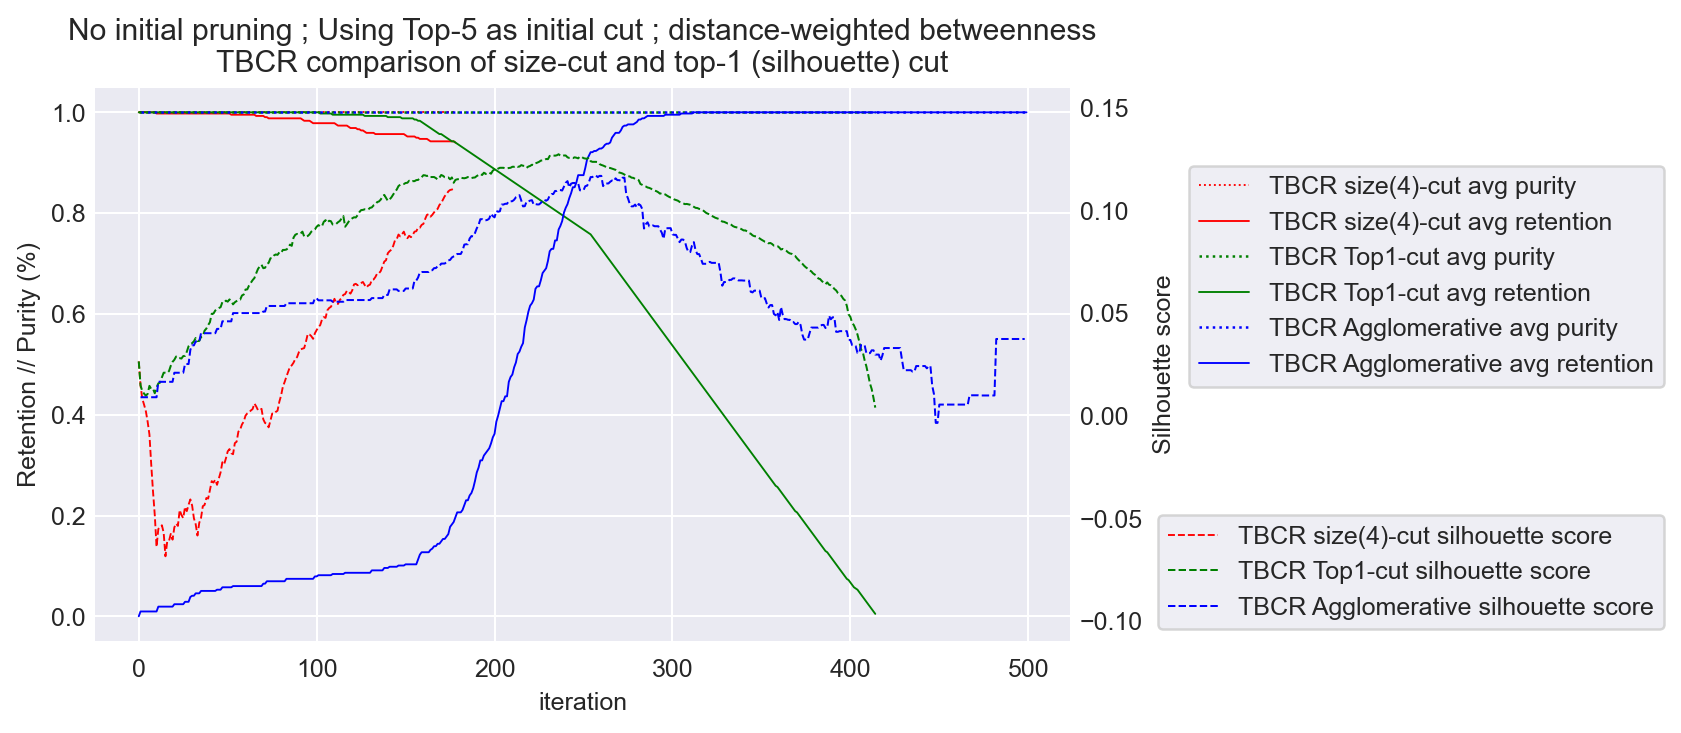

In [69]:
f,a = plt.subplots(1,1, figsize=(7,4))
a2 = a.twinx()
a.set_title('No initial pruning ; Using Top-5 as initial cut ; distance-weighted betweenness\nTBCR comparison of size-cut and top-1 (silhouette) cut')

a.plot(range(len(size_purities)), size_purities, lw=.75, ls=':', c='r',
       label='TBCR size(4)-cut avg purity')
a.plot(range(len(size_retentions)), size_retentions, lw=.75, ls='-', c='r',
       label='TBCR size(4)-cut avg retention')
a2.plot(range(len(size_scores)), size_scores, lw=.75, ls='--', c='r',
       label='TBCR size(4)-cut silhouette score')

a.plot(range(len(topn_purities)), topn_purities, lw=1, ls=':', c='g',
       label='TBCR Top1-cut avg purity')
a.plot(range(len(topn_retentions)), topn_retentions, lw=.75, ls='-', c='g',
       label='TBCR Top1-cut avg retention')
a2.plot(range(len(topn_scores)), topn_scores, lw=.8, ls='--', c='g',
       label='TBCR Top1-cut silhouette score')

a.plot(range(len(cluster_test['mean_purity'].values)), cluster_test['mean_purity'].values, lw=1, ls=':', c='b',
       label='TBCR Agglomerative avg purity')
a.plot(range(len(cluster_test['retention'].values)), cluster_test['retention'].values, lw=.75, ls='-', c='b',
       label='TBCR Agglomerative avg retention')
a2.plot(range(len(cluster_test['silhouette'].values)), cluster_test['silhouette'].values, lw=.8, ls='--', c='b',
       label='TBCR Agglomerative silhouette score')

# Align the tick marks
a.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from primary y-axis
a2.yaxis.set_tick_params(which='both', length=0)  # Remove tick marks from secondary y-axis
# Align the gridlines
a.grid(True)
a2.grid(False)  # Disable secondary y-axis gridlines
a.set_ylabel('Retention // Purity (%)')
a2.set_ylabel('Silhouette score')
a2.set_ylim([-0.11,0.16])
a2.legend(bbox_to_anchor=(1.62,.25))
a.set_xlabel('iteration')
a.legend(bbox_to_anchor=(1.62,.88))
# f.savefig(f'../output/240618_NestedKCV_CNNVAE/notebook_figs/{filename}TBCR_silhouette.png', dpi=150, bbox_inches='tight')


### retpur curves

In [ ]:
# Identify best point (based on Silhouette score) for each of the 4 conditions and add them as scatter points
best_sh_ts128 = sh_rets_ts128[np.argmax(sh_scores_ts128)], sh_purities_ts128[np.argmax(sh_scores_ts128)]
best_it_ts128 = it_rets_ts128[np.argmax(it_scores_ts128)], it_purities_ts128[np.argmax(it_scores_ts128)]
best_sh_os128 = sh_rets_os128[np.argmax(sh_scores_os128)], sh_purities_os128[np.argmax(sh_scores_os128)]
best_it_os128 = it_rets_os128[np.argmax(it_scores_os128)], it_purities_os128[np.argmax(it_scores_os128)]
best_sh_os256 = sh_rets_os256[np.argmax(sh_scores_os256)], sh_purities_os256[np.argmax(sh_scores_os256)]
best_it_os256 = it_rets_os256[np.argmax(it_scores_os256)], it_purities_os256[np.argmax(it_scores_os256)]
best_sh_agg = sh_rets_agg[np.argmax(sh_scores_agg)], sh_purities_agg[np.argmax(sh_scores_agg)]
best_it_agg = it_rets_agg[np.argmax(it_scores_agg)], it_purities_agg[np.argmax(it_scores_agg)]
best_tbcr_sh = tbcr_sh_rets[np.argmax(tbcr_sh_scores)], tbcr_sh_purities[np.argmax(tbcr_sh_scores)]
best_tbcr_it = tbcr_it_rets[np.argmax(tbcr_it_scores)], tbcr_it_purities[np.argmax(tbcr_it_scores)]
best_tcrdist_sh = tcrdist_sh_rets[np.argmax(tcrdist_sh_scores)], tcrdist_sh_purities[np.argmax(tcrdist_sh_scores)]
best_tcrdist_it = tcrdist_it_rets[np.argmax(tcrdist_it_scores)], tcrdist_it_purities[np.argmax(tcrdist_it_scores)]



In [ ]:
palette=get_palette('cool', 3)
sns.palplot(palette)
c_ts128 = palette[0]
c_os128 = palette[1]
c_os256 = palette[2]
c_agg = 'r'
c_tbcr='g'
c_tcrdist='y'
f,a = plt.subplots(1,1, figsize=(10, 10))
lw=.75
marker_size=12
marker='*'
# TBCRalign
a.plot(tbcr_cluster_testset['retention'].values[1:-1], tbcr_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TBCRalign + Agglomerative Clustering', lw=0.5, ls='-', c=c_tbcr)
a.plot(tbcr_sh_rets, tbcr_sh_purities, label = 'TBCRalign MST + Top 1 Cut', lw = lw, ls='--', c=c_tbcr)
a.scatter(best_tbcr_sh[0], best_tbcr_sh[1], c=c_tbcr, label = 'Best (Silhouette) TBCRalign MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)

# tcrdist3
a.plot(tcrdist_cluster_testset['retention'].values[1:-1], tcrdist_cluster_testset['mean_purity'].values[1:-1], 
       label = 'tcrdist + Agglomerative Clustering', lw=0.5, ls='-', c=c_tcrdist)
a.plot(tcrdist_sh_rets, tcrdist_sh_purities, label = 'tcrdist3 MST + Top 1 Cut', lw = lw, ls='--', c=c_tcrdist)
a.scatter(best_tcrdist_sh[0], best_tcrdist_sh[1], c=c_tcrdist, label = 'Best (Silhouette) tcrdist3 MST + Top 1 Cut', s=marker_size, marker=marker, lw=lw)


# TS128
a.plot(ts128_cluster_testset['retention'].values[1:-1], ts128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'TS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_ts128)
a.plot(sh_rets_ts128, sh_purities_ts128, label = 'TS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_ts128)
a.scatter(best_sh_ts128[0], best_sh_ts128[1], c=c_ts128, label = 'Best (Silhouette) TS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS128
a.plot(os128_cluster_testset['retention'].values[1:-1], os128_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS128 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os128)

a.plot(sh_rets_os128, sh_purities_os128, label = 'OS128 MST + Top 1 Cut', lw = lw, ls='--', c=c_os128)
a.scatter(best_sh_os128[0], best_sh_os128[1], c=c_os128, label = 'Best (Silhouette) OS128 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# OS256
a.plot(os256_cluster_testset['retention'].values[1:-1], os256_cluster_testset['mean_purity'].values[1:-1], 
       label = 'OS256 + Agglomerative Clustering', lw=0.5, ls='-', c=c_os256)

a.plot(sh_rets_os256, sh_purities_os256, label = 'OS256 MST + Top 1 Cut', lw = lw, ls='--', c=c_os256)
a.scatter(best_sh_os256[0], best_sh_os256[1], c=c_os256, label = 'Best (Silhouette) OS256 MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

# Aggregated
a.plot(agg_cluster_testset['retention'].values[1:-1], agg_cluster_testset['mean_purity'].values[1:-1], 
       label = 'AggDM + Agglomerative Clustering', lw=0.5, ls='-', c=c_agg)

a.plot(sh_rets_agg, sh_purities_agg, label = 'AggDM MST + Top 1 Cut', lw = lw, ls='--', c=c_agg)
a.scatter(best_sh_agg[0], best_sh_agg[1], c=c_agg, label = 'Best (Silhouette) AggDM MST + Top 1 Cut', 
          s=marker_size, marker=marker, lw=lw)

a.legend()
a.set_ylim([.5,1.])
a.set_xlim([.5,1.])
a.set_xlabel('Retention', fontsize=12, fontweight='semibold')
a.set_ylabel('Mean purity', fontsize=12, fontweight='semibold')
a.set_title('Purity Retention curves for valid set, Filtered (8peps) and subsampled\n Agglomerative vs MST cutting ; Retention/Purity range : (0.5-1.0)', fontweight='semibold', fontsize=14)

# Do run merging Covid (Francis) and Healthy (Garner) studies

<Axes: title={'center': 'Garner Healthy'}, ylabel='Frequency'>

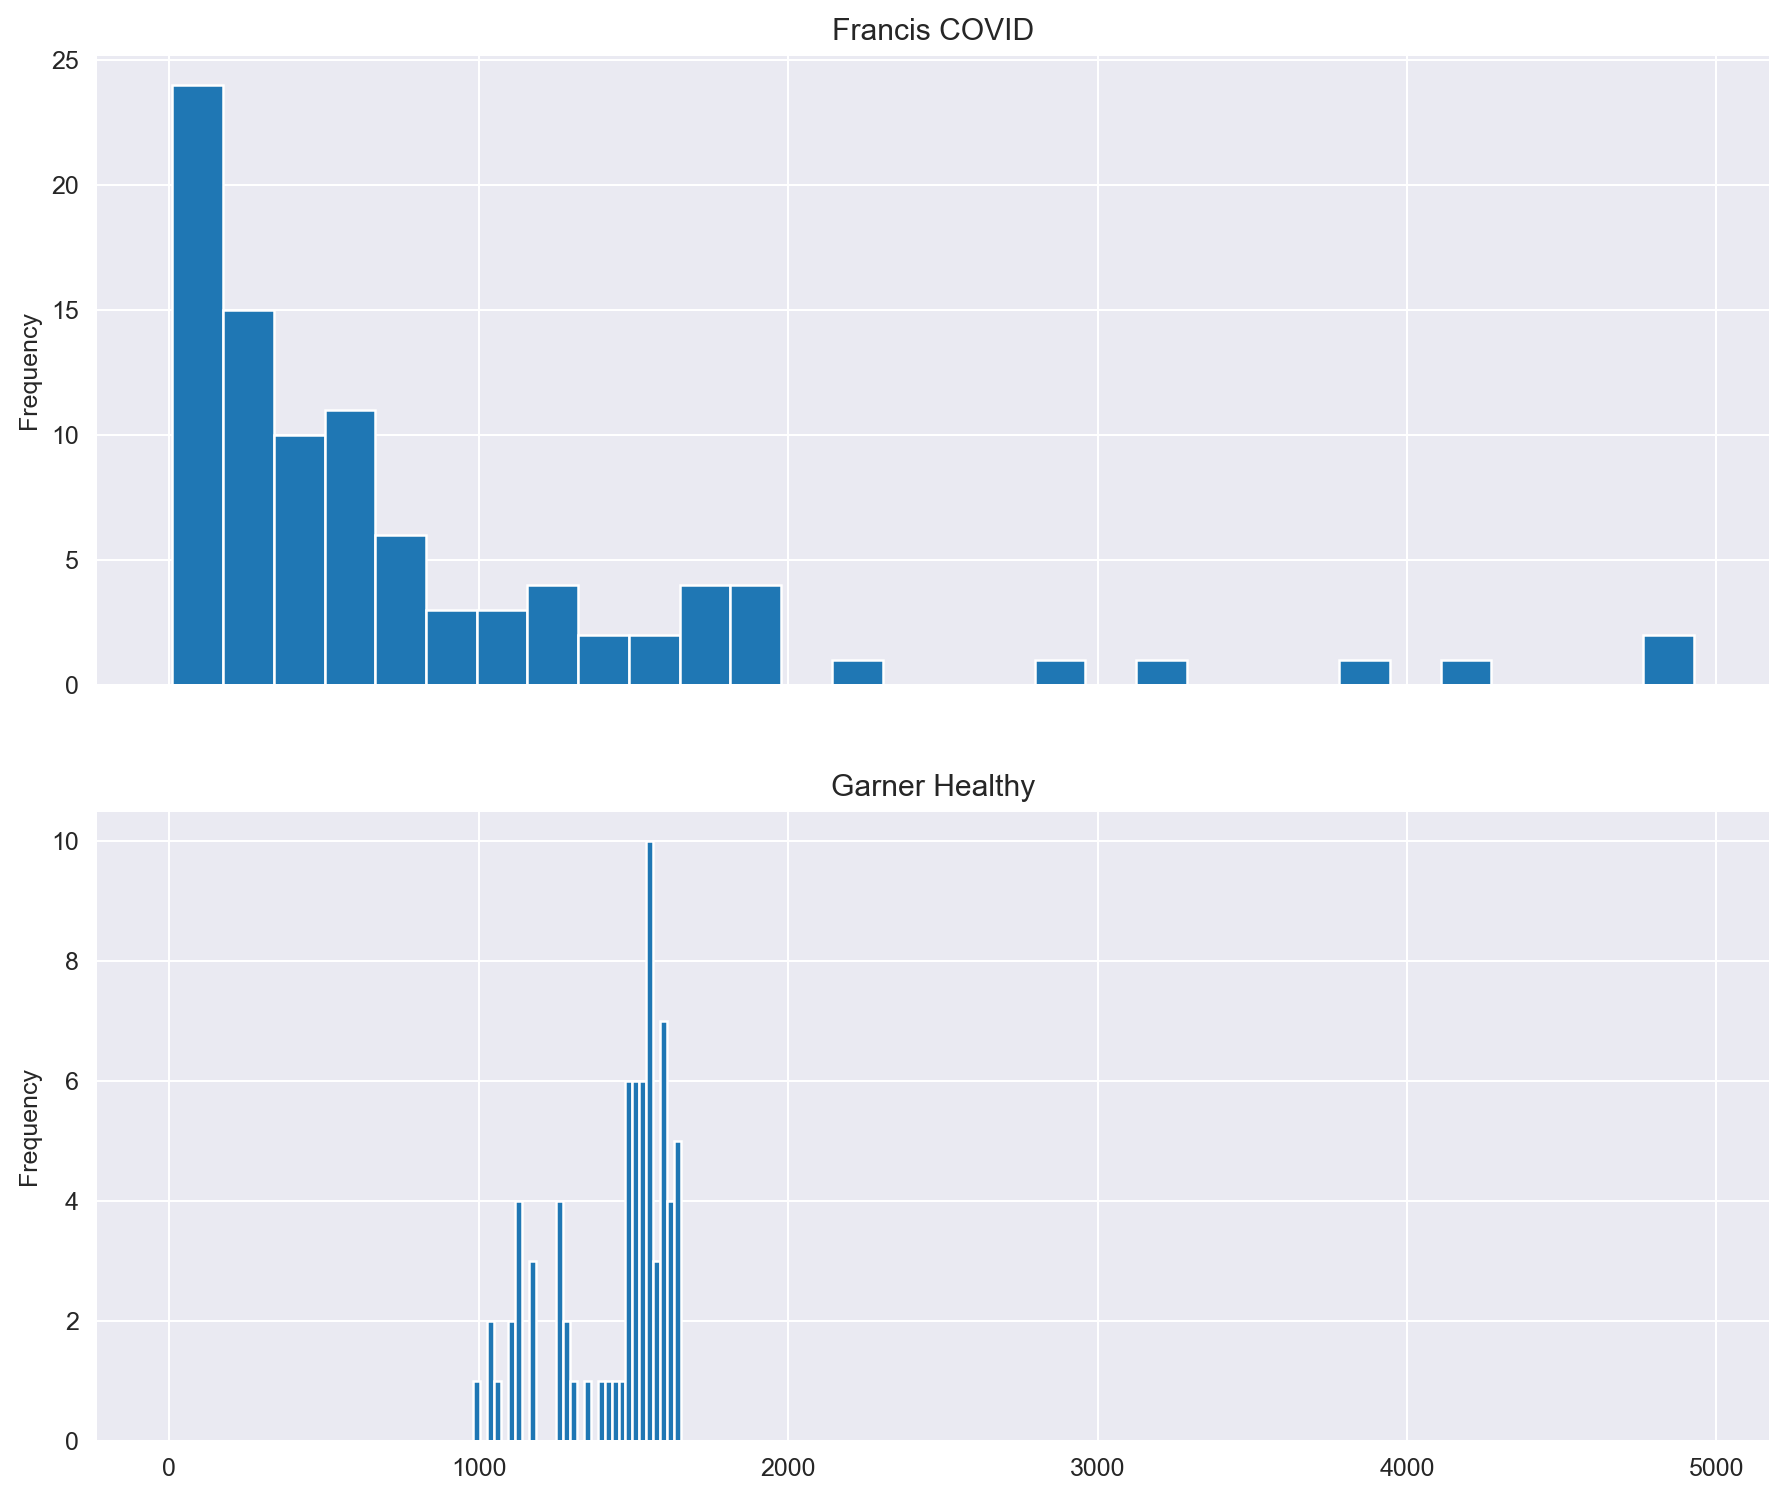

In [40]:
garner_pbmc = meta_df.query('Author.str.contains("Garner")').query('TSource=="pbmc"')
francis_pbmc = meta_df.query('Author.str.contains("Franc")')
f,a = plt.subplots(2,1, figsize=(12,10), sharex=True)
ax = a.ravel()
francis_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[0], title='Francis COVID')
garner_pbmc.n_unique.plot(kind='hist', bins=30, ax = ax[1], title='Garner Healthy')

In [59]:
n=160
print(len(garner_pbmc.query("n_unique>=@n")),len(francis_pbmc.query("n_unique>=@n")))
garner_160 = garner_pbmc.query("n_unique>=@n").sort_values('n_unique')
francis_160 = francis_pbmc.query("n_unique>=@n").sort_values('n_unique')

72 72


In [64]:
garner

filename                          SRR25409212_1_Paired_All.csv
relpath         ../data/OTS/human/SRR25409212_1_Paired_All.csv
Run                                                SRR25409212
Link                 https://pubmed.ncbi.nlm.nih.gov/37580605/
Author                                           Garner et al.
Disease                                                healthy
CancerType                                                none
Age                                                         no
Longitudinal                                                no
Species                                                  human
Strain                                                    none
TSource                                                   pbmc
TType                                                     cd8+
TSubtype                             il12_il18_cd28_stimulated
Treatment                                            untreated
Subject                                            4.1_

In [65]:
for i in range(len(garner_160)):
    # Do a zip and get the two files, read the dfs, and merge
    garner = garner_160.iloc[i]
    francis = francis_160.iloc[i]
    garner, garner_metadata = read_ots_unique(garner['relpath'])
    francis, francis_metadata = read_ots_unique(francis['relpath'])

In [70]:
g0 = garner_160.iloc[0]
f0 = francis_160.iloc[0]
garner, _ = read_ots_unique(g0['relpath'])
francis, _ = read_ots_unique(f0['relpath'])
mixed_test = pd.concat([garner.sample(100, random_state=13), francis.sample(100, random_state=13)])
mixed_test.to_csv('../data/OTS/mixed_test_data.csv', index=False)

In [76]:
mixed_test.head(2)

,tcr,v_beta,d_beta,j_beta,B1,B2,B3,v_alpha,d_alpha,j_alpha,A1,A2,A3,Link,Disease,CancerType,Source,Subject,count
611,TSGFNGNVLDGLAVMDSNYQLIWNHNNSYGVQDASSDRDTGELF,TRBV10-1*01,TRBD1*01,TRBJ2-2*01,WNHNN,SYGVQD,ASSDRDTGELF,TRAV1-2*01,NaN,TRAJ33*01,TSGFNG,NVLDGL,AVMDSNYQLI,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,2
814,TSGFNGNVLDGLAVRDSDYKLSMRHNASNTAGTASSPGGPSGANVLT,TRBV6-4*02,TRBD2*01,TRBJ2-6*01,MRHNA,SNTAGT,ASSPGGPSGANVLT,TRAV1-2*01,NaN,TRAJ20*01,TSGFNG,NVLDGL,AVRDSDYKLS,https://pubmed.ncbi.nlm.nih.gov/37580605/,healthy,none,pbmc,4.1_4.2_4.3,1


In [79]:
dm = pd.read_csv('../data/mixed_test_data_TBCR_distmatrix.csv', index_col=0)
dm

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,Disease,Source,count
q_index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.141811,0.127153,0.122996,0.111405,0.106975,0.085607,0.106382,0.111616,0.099076,...,0.178386,0.190997,0.181785,0.186164,0.183630,0.193406,0.228023,healthy,pbmc,2
1,0.141811,0.000000,0.073688,0.113270,0.144548,0.134624,0.118861,0.151282,0.108692,0.121867,...,0.188008,0.190229,0.200785,0.194458,0.164207,0.204848,0.210851,healthy,pbmc,1
2,0.127153,0.073688,0.000000,0.091515,0.125295,0.119858,0.110294,0.133866,0.102694,0.108938,...,0.169953,0.160391,0.181860,0.179263,0.160146,0.193510,0.219921,healthy,pbmc,1
3,0.122996,0.113270,0.091515,0.000000,0.138677,0.119663,0.112965,0.156350,0.125653,0.122678,...,0.193152,0.172840,0.153881,0.187570,0.175297,0.200072,0.211785,healthy,pbmc,2
4,0.111405,0.144548,0.125295,0.138677,0.000000,0.107202,0.108565,0.071701,0.119859,0.115201,...,0.168632,0.153100,0.189398,0.199578,0.204705,0.188562,0.213830,healthy,pbmc,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.181785,0.200785,0.181860,0.153881,0.189398,0.191139,0.165232,0.208100,0.191741,0.163233,...,0.207963,0.169868,0.000000,0.182608,0.194420,0.222556,0.223013,covid,pbmc,1
196,0.186164,0.194458,0.179263,0.187570,0.199578,0.199532,0.195456,0.206798,0.182914,0.192035,...,0.180796,0.176192,0.182608,0.000000,0.155323,0.219110,0.204618,covid,pbmc,2
197,0.183630,0.164207,0.160146,0.175297,0.204705,0.189491,0.175044,0.211471,0.162908,0.180056,...,0.181114,0.186666,0.194420,0.155323,0.000000,0.203289,0.229157,covid,pbmc,1
